# DFT vs LSTM

Note: 
- We'll only deal with Real valued signals
- We'll use torch as we'll deal with LSTMs later, but the commands for numpy and scipy are almost identical.
- We'll set the sample rate `fs=1`

First let's review some things that we need to know about the Discrete Fourier Transform (DFT)

**1) FFT stands for Fast Fourier Transform and is the algorithm typically used to compute the DFT.**

Hence torch.fftm numpy.fft, scipy.fft.

**2) The DFT is a linear operation that maps a signal of N samples onto N complex values which represent the amplitudes and phases of the harmonics/components that make up the signal.**

The frequencies of these components are determined by `N` and the sample rate `fs` as `f[k]=k*fs/N`. 
So `f[k]=k/N` in our case, where `k={-N/2}` 

**3) While there are N components in the DFT, these only correspond to about N//2 different and unique fundamental frequencies.**

Specifically,

if N is even:
- `N/2`  positive frequency components, including the DC component (the constant value/offset of the signal). 
- `1` value for the Nyquist component `fs/2` (the highest possible frequency, which is half the sample rate since k_max=) 
- So `N/2+1` in total.

if N is odd:
- `(N+1)/2`  positive frequency components including the DC component.
-  Note that we don't reach the Nyquist component in this case, the highest frequency component in the DFT will be slightly below it.

That is becasue the DFT maps the signal onto a given positive frequency and its negative separately. The two are functionally equivalent and when dealing with real valued signals the two corresponding amplitueds are added together and we just work with the positive frequency.
Example: Given a signal with 10 samples

In [11]:
import torch
# Even N
N = 16
expected_components = N/2 + 1
y = torch.arange(N)
dft = torch.fft.rfft(y)
print(len(dft), expected_components, dft.dtype)
# Odd N
N=15
expected_components = (N+1)/2
y = torch.arange(N)
dft = torch.fft.rfft(y)
print(len(dft), expected_components, dft.dtype)


9 9.0 torch.complex64
8 8.0 torch.complex64


Next let's define some helper functions for doing DFT.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import wandb
from pathlib import Path

np.random.seed(0)  # Seed for reproducibility


def generate_signal(num_samples=100):
    """
    :param num_samples: Total number of samples in the signal
    :return: 
    """
    num_periods = np.random.randint(3, 7)  # Randomly choose how many periods to combine
    periods = np.random.randint(2, 200, num_periods)  # Period lengths in samples
    phases = np.random.rand(num_periods) * 2 * np.pi
    print("PERIDOS", periods)

    # Generate random amplitudes and normalize them to sum to 1
    amplitudes = np.random.rand(num_periods)
    amplitudes /= np.sum(amplitudes)

    # Sample indices
    samples = np.arange(num_samples)

    # Generate a random continuous periodic signal
    signal = sum(amplitude * np.sin(2 * np.pi * (1 / period) * samples + phase) for amplitude, period, phase in zip(amplitudes, periods, phases))
    signal = signal / np.max(np.abs(signal))  # Normalize signal

    # Add random noise to the signal
    noise = np.random.normal(0, 0.1, signal.shape)
    signal += noise
    signal = signal / np.max(np.abs(signal))  # Normalize signal again

    return samples, torch.from_numpy(signal)



def get_fft_harmonics(orignal_signal, analysis_samples, hamming_smoothing=False):
    if hamming_smoothing:
        signal_window = orignal_signal[:analysis_samples]
        window = torch.hamming_window(analysis_samples, periodic=False)
        signal_window = signal_window * window
        fft_result = torch.fft.rfft(signal_window)
    else:
        fft_result = torch.fft.rfft(orignal_signal[:analysis_samples])
    amplitudes = torch.abs(fft_result) / analysis_samples
    phases = torch.angle(fft_result)
    
    # Double the amplitudes for non-DC components
    # Note: The last component should not be doubled if N is even and represents the Nyquist frequency
    if analysis_samples % 2 == 0:
        # If the original signal length is even, don't double the last component (Nyquist frequency)
        amplitudes[1: -1] *= 2
    else:
        # If the original signal length is odd, all components except the DC can be doubled
        amplitudes[1:] *= 2
    return amplitudes, phases

def get_signal_from_harmonics(amplitudes, phases, num_samples):
    analysis_samples = len(amplitudes) * 2 - 2  # Adjust for rfft output length
    reconstructed_signal = torch.zeros(num_samples, dtype=torch.complex64)
    for index, (amplitude, phase) in enumerate(zip(amplitudes, phases)):
        reconstructed_signal += amplitude * torch.exp(1j * (2 * torch.pi * index * torch.arange(num_samples) / analysis_samples + phase))

    # Return the real part of the reconstructed signal
    return reconstructed_signal.real


def reconstruct_signal_fft(orignal_signal, analysis_samples, hamming_smoothing=False):
    # Perform FFT on the entire signal
    amplitudes, phases = get_fft_harmonics(orignal_signal, analysis_samples, hamming_smoothing)

    # Return the real part of the reconstructed signal
    return get_signal_from_harmonics(amplitudes, phases, len(orignal_signal))


## Exploration

Let's first define a function that takes care of plotting the original signal, the reconstructed signal and the amplitudes and phases of the harmonics.

In [1]:

def plot_signal_and_fft(signal: torch.Tensor, train_test_split_idx: int, hamming_smoothing: bool = False):
    assert (W := signal.shape[0]) >= train_test_split_idx
    t_split = torch.arange(train_test_split_idx)
    t_full = torch.arange(W)


    amplitudes, phases = get_fft_harmonics(signal, train_test_split_idx, hamming_smoothing)
    frequency_bins = np.arange(len(amplitudes), dtype=np.float16)

    plt.figure(figsize=(15, 3))

    plt.subplot(1, 3, 1)
    plt.plot(t_full, signal, label="original")
    plt.plot(t_full, get_signal_from_harmonics(amplitudes, phases, W), '-x', label="fft reconstruction")
    plt.axvspan(0, train_test_split_idx, color='grey', alpha=0.3)
    plt.xlabel('t [samples]')
    plt.legend(loc='best')
    plt.title('Signal')
    
    fft_frequencies = frequency_bins/train_test_split_idx
    plt.subplot(1, 3, 2)
    plt.xscale('log')
    plt.plot(fft_frequencies, amplitudes)
    plt.xlabel('Frequency [1/samples]')
    plt.title('Amplitudes')

    fft_periods = frequency_bins.copy()
    fft_periods[1:]=train_test_split_idx/fft_periods[1:]
    plt.subplot(1, 3, 3)
    plt.plot(frequency_bins, amplitudes)
    top_5_indices = np.argsort(amplitudes)[-4:]
    top_5_indices[0]=1
    plt.xscale('log')
    plt.xticks(frequency_bins[top_5_indices],fft_periods[top_5_indices], rotation=70)
    plt.xlabel('T [samples]')
    plt.title('Amplitudes')


    plt.tight_layout()
    plt.show()

# y =  0.4*torch.sin(2*np.pi*(1./12) * t_W) + 0.2*torch.sin(2*np.pi*(1./4) * t_W) + 0.2*torch.sin(2*np.pi*(1./67) * t_W)
# _, y = generate_signal(W)
# y=targets-torch.mean(targets)
_, y = generate_signal(100)
plot_signal_and_fft(y, 50)


NameError: name 'torch' is not defined

PERIDOS [ 60   7  75  90 142  61]


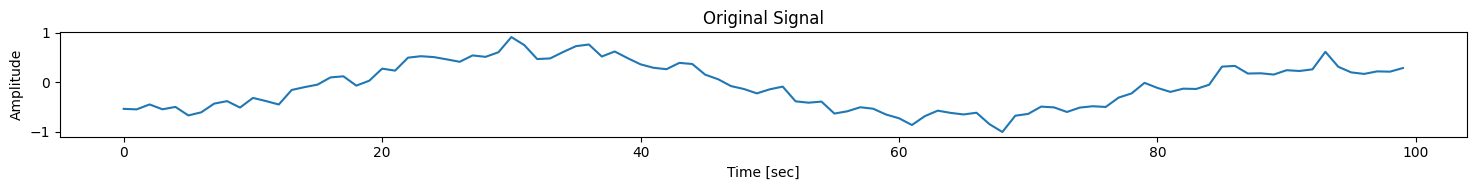

In [27]:
t, signal = generate_signal()
# Plotting
plt.figure(figsize=(15, 2))

plt.plot(t, signal)
plt.title('Original Signal')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()

## Real data

In [ ]:
import pandas as pd
import torch

# Replace 'your_file.csv' with the path to your CSV file
# and 'your_column_name' with the name of the column you want to read.
csv_file = './data/data_easier.csv'
column_name = 'target'

# Read the CSV file using pandas
df = pd.read_csv(csv_file)

# Select the column and convert it to a NumPy array
column_data = df[column_name].to_numpy()

plt.plot(range(len(column_data)), column_data)
# Convert the NumPy array to a PyTorch tensor
targets = torch.tensor(column_data, dtype=torch.float32)  # or torch.float64 for double precision

print(len(targets))

In [3]:
class SignalDataset(Dataset):
    def __init__(self, size):
        """
        :param size: Number of samples in the dataset
        """
        self.size = size

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        _, signal = generate_signal()
        # print("__getitem__")
        # Convert to PyTorch tensors
        signal = torch.tensor(signal, dtype=torch.float)
        target = torch.roll(signal, -1, dims=0)
        return signal.unsqueeze_(dim=-1), target.unsqueeze_(dim=-1)

In [4]:

class LSTMPredictor(torch.nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=200, output_size=1):
        super(LSTMPredictor, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = torch.nn.LSTM(input_size, hidden_layer_size, batch_first=True, num_layers=2)
        self.leaky_relu = torch.nn.LeakyReLU()
        self.linear_1 = torch.nn.Linear(hidden_layer_size, int(hidden_layer_size/2))
        self.linear_2 = torch.nn.Linear(int(hidden_layer_size/2), output_size)

    def forward(self, input_seq):
        x, _ = self.lstm(input_seq)
        x =  self.leaky_relu(x)
        x = self.linear_1(x)
        x = self.leaky_relu(x)
        x = self.linear_2(x)
        return x


In [5]:
# Nicer summary of model
def count_parameters(model):
    from prettytable import PrettyTable
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

model = LSTMPredictor()

pram_count = count_parameters(model)
LR = 0.002
device =  torch.device("cpu") if torch.backends.mps.is_available() else torch.device("cpu")
print("DEVICE", device)
model.to(device)

checkpoint_path = './checkpoints/m4sf3o8e/2000_epochs_m4sf3o8e'
# checkpoint_path = None

if checkpoint_path:
    checkpoint_data = checkpoint_path.split("/")[-1].split("_")
    start_epochs = int(checkpoint_data[0])
else:
    start_epochs = 0


+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| lstm.weight_ih_l0 |    800     |
| lstm.weight_hh_l0 |   160000   |
|  lstm.bias_ih_l0  |    800     |
|  lstm.bias_hh_l0  |    800     |
| lstm.weight_ih_l1 |   160000   |
| lstm.weight_hh_l1 |   160000   |
|  lstm.bias_ih_l1  |    800     |
|  lstm.bias_hh_l1  |    800     |
|  linear_1.weight  |   20000    |
|   linear_1.bias   |    100     |
|  linear_2.weight  |    100     |
|   linear_2.bias   |     1      |
+-------------------+------------+
Total Trainable Params: 504201
DEVICE cpu


In [34]:
common_kwargs={
    'project':"time-series",
    'tags': [f"lr_{LR}", f"params_{pram_count}"],
    'name':'harmonic-signal-prediction-lstm',
}
if checkpoint_path:
    wandb_id = checkpoint_data[-1]
    model.load_state_dict(torch.load(checkpoint_path))

    wandb.init(
        **common_kwargs,
        id=wandb_id,
        resume=True
    )
else:
    wandb.init(
        **common_kwargs
    )

In [39]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
dataset = SignalDataset(size=1000) 
val_dataset = SignalDataset(size=1000)  
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
epochs = 2001


for i in range(start_epochs, start_epochs + epochs + 1):
    model.train()
    train_loss = 0
    for seq, labels in dataloader:
        optimizer.zero_grad()
        y_pred = model(seq.to(device))
        single_loss = loss_function(y_pred, labels.to(device))
        single_loss.backward()
        train_loss += single_loss
        optimizer.step()

    if i % 25 == 0:
        model.eval()
        val_loss = 0
        for seq, labels in val_dataloader:
            y_pred = model(seq.to(device))
            single_loss = loss_function(y_pred, labels.to(device))
            val_loss += single_loss
        print(f'TRAIN: epoch: {i},  loss: {train_loss.item()}')
        print(f'VAL: epoch: {i},  val loss: {val_loss.item()} \n')
        wandb.log({"train loss": train_loss.item(), "val loss": val_loss.item()}, i)
        if i % 100 == 0:
            Path(f"./checkpoints/{wandb.run.id}/").mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), f'./checkpoints/{wandb.run.id}/{i}_epochs_{wandb.run.id}')
        

TRAIN: epoch: 0,  loss: 3.9175126552581787
VAL: epoch: 0,  val loss: 1.217633605003357 

TRAIN: epoch: 25,  loss: 0.6162568926811218
VAL: epoch: 25,  val loss: 0.6265370845794678 

TRAIN: epoch: 50,  loss: 0.5738358497619629
VAL: epoch: 50,  val loss: 0.5825968980789185 

TRAIN: epoch: 75,  loss: 0.5353890061378479
VAL: epoch: 75,  val loss: 0.5231268405914307 

TRAIN: epoch: 100,  loss: 0.5329431295394897
VAL: epoch: 100,  val loss: 0.5260406136512756 

TRAIN: epoch: 125,  loss: 0.5344786047935486
VAL: epoch: 125,  val loss: 0.531976580619812 

TRAIN: epoch: 150,  loss: 0.5182275772094727
VAL: epoch: 150,  val loss: 0.5091279149055481 

TRAIN: epoch: 175,  loss: 0.500478982925415
VAL: epoch: 175,  val loss: 0.5151376128196716 

TRAIN: epoch: 200,  loss: 0.5040776133537292
VAL: epoch: 200,  val loss: 0.5071827173233032 

TRAIN: epoch: 225,  loss: 0.5043283104896545
VAL: epoch: 225,  val loss: 0.5057314038276672 

TRAIN: epoch: 250,  loss: 0.5362386107444763
VAL: epoch: 250,  val loss: 

In [40]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


train loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val loss,█▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂
train loss,0.48085
val loss,0.46116


In [6]:
model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

PERIDOS [ 31  30 135  86]


/var/folders/9l/khjvspfx1bg14csgvz4fpk_00000gn/T/ipykernel_61461/1536760959.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signal = torch.tensor(signal, dtype=torch.float)


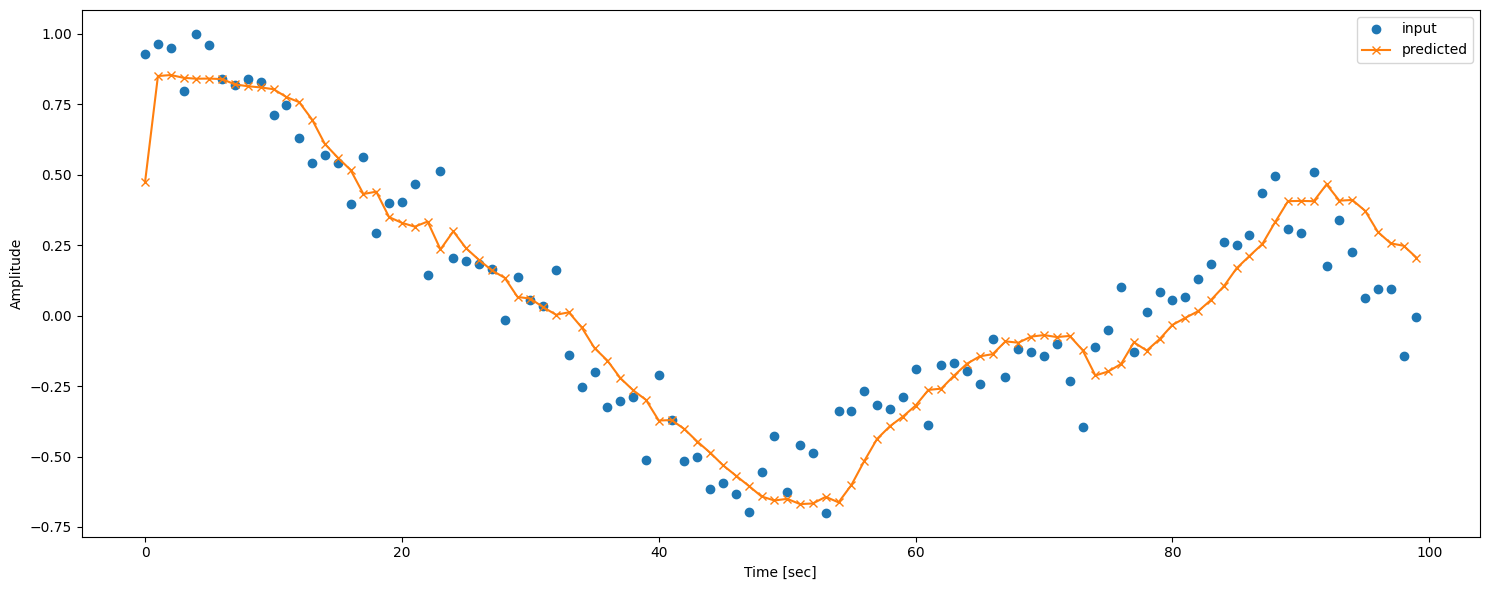

In [25]:
t, signal = generate_signal()
signal = torch.tensor(signal, dtype=torch.float)
pred = model(signal.view(1, len(signal), 1))
predicted_signal = pred.view(len(signal)).detach()
predicted_signal = torch.roll(predicted_signal, 1, dims=0)

# Plotting
plt.figure(figsize=(15, 6))

plt.plot(t, signal, 'o', label='input')
plt.plot(t, predicted_signal, '-x', label='predicted')
plt.legend(loc='best')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()

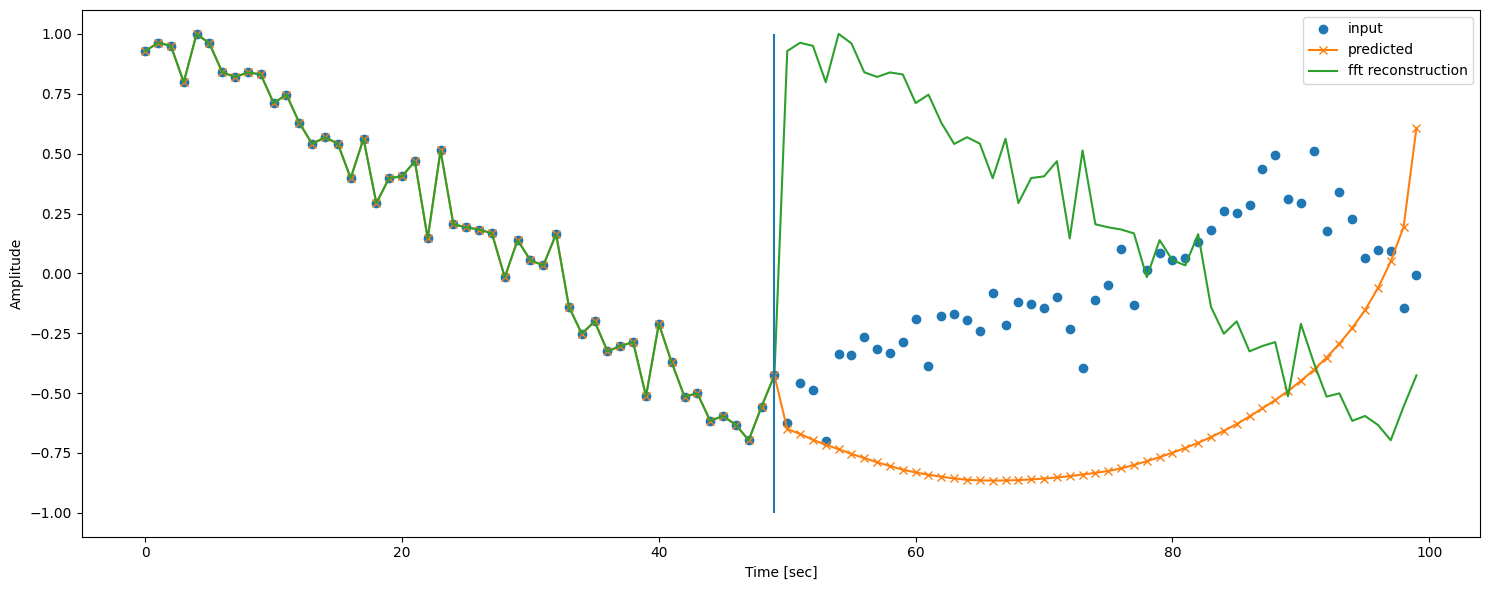

In [26]:
signal_continuation_autoreg = torch.clone(signal)
signal_continuation_autoreg[50:] = 0
for i in range(len(signal[50:])):
    pred = model(signal_continuation_autoreg.view(1, len(signal_continuation_autoreg), 1))
    pred = pred.view(len(signal_continuation_autoreg)).detach()
    signal_continuation_autoreg[50+i] = pred[50+i-1]

# Plotting
plt.figure(figsize=(15, 6))

plt.plot(t, signal, 'o', label='input')
plt.plot(t, signal_continuation_autoreg, '-x', label='predicted')
plt.plot(t, reconstruct_signal_fft(signal, 50), label='fft reconstruction')
plt.legend(loc='best')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')

plt.vlines(t[49], -1, 1)

plt.tight_layout()
plt.show()